In [1]:
from glob import glob

image_files = glob("social-posts-dailyds/*.jpg")

text_files = glob("social-posts-dailyds/*.txt")

len(image_files), len(text_files)


(40, 40)

In [3]:
image_files[1], text_files[1]

('social-posts-dailyds\\10.jpg', 'social-posts-dailyds\\10.txt')

In [4]:
documents = []

for i in range(1, len(image_files)+1):
    text_file  = f'./social-posts-dailyds/{i}.txt'
    image_file = f'./social-posts-dailyds/{i}.jpg'
    
    text = open(text_file).read()
    doc = {"text": text, "image":image_file}
    documents.append(doc)

In [5]:
documents[11]

{'text': 'Mixed precision training explained step-by-step.\n\nAlmost all models use this to speed up training.\n\nThe motivation is simple.\n\nTypical deep learning frameworks are really conservative when assigning data types. They usually allocate 64-bit or 32-bit to get higher precision.\n\nHowever, this precision involves additional memory utilization, which is not necessary every time. Thus, in most cases, we are not optimal at efficiently allocating memory.\n\nUsing lower-precision formats, like float16, can dramatically reduce memory footprint and speed up training since operations like matrix multiplication run much faster under smaller precision.\n\nTypical speedups can be anywhere between 2-4x, *without heavily comprising model accuracy.*',
 'image': './social-posts-dailyds/12.jpg'}

Here's an intuitive technique to measure feature importance.

Of the many techniques, I often find “Shuffle Feature Importance” to be a pretty handy and intuitive technique to measure feature importance.

As the name suggests, it observes how shuffling a feature influences the model performance.

The visual below illustrates this technique in four simple steps:

- Train the model and measure its performance → P1.
- Shuffle one feature randomly and measure performance again → P2 (model is NOT trained again).
- Measure feature importance using performance drop = (P1-P2).
- Repeat for all features.

The idea makes intuitive sense as well.

Simply put, if we randomly shuffle just one feature and everything else stays the same, then the performance drop will indicate how important that feature is.
- If the drop is HIGH → the feature has a strong influence on the model’s predictions.
- If the drop is LOW → the feature has a low influence on the model’s predictions.

Do note that to eliminate

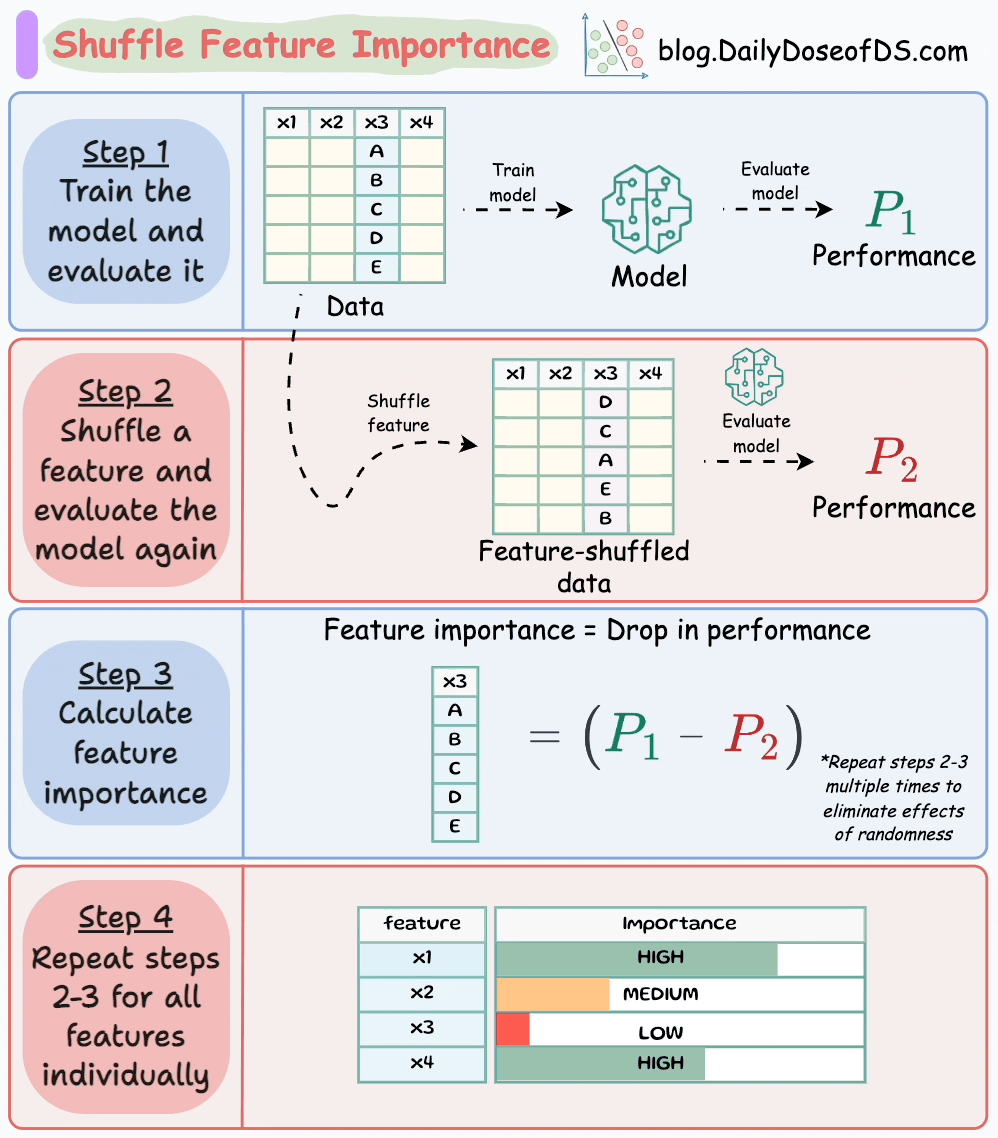

In [28]:
import random 
from IPython.display import display
num = random.randint(0, len(documents) - 1)

# print text
print(documents[num]["text"])

# display image
display(Image.open(documents[num]["image"]))


In [29]:
%pip install fastembed

  Using cached onnxruntime-1.20.1-cp311-cp311-win_amd64.whl.metadata (4.7 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
  Using cached pyreadline3-3.5.4-py3-none-any.whl.metadata (4.7 kB)
Using cached onnxruntime-1.20.1-cp311-cp311-win_amd64.whl (11.3 MB)
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl (434 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
Using cached pyreadline3-3.5.4-py3-none-any.whl (83 kB)
Note: you may need to restart the kernel to use updated packages.


In [34]:
from fastembed import TextEmbedding, ImageEmbedding

class EmbedData:
    def __init__(self,
                 documents,
                 text_model_name="Qdrant/clip-ViT-B-32-text",
                 image_model_name="Qdrant/clip-ViT-B-32-vision"):

        # Initialize text embedding model
        self.documents = documents
        self.text_model = TextEmbedding(model_name=text_model_name)
        self.text_embed_dim = self.text_model._get_model_description(text_model_name)["dim"]
        
        # Initialize image embedding model
        self.image_model = ImageEmbedding(model_name=image_model_name)
        self.image_embed_dim = self.image_model._get_model_description(image_model_name)["dim"]

        
    def embed_images(self, images):
        image_embeddings = list(self.image_model.embed(images))
        return image_embeddings

In [35]:
embeddata = EmbedData(documents)

embeddata.text_embeds  = embeddata.embed_texts([doc["text"] for doc in documents])

embeddata.image_embeds = embeddata.embed_images([doc["image"] for doc in documents])

TypeError: 'DenseModelDescription' object is not subscriptable

In [ ]:
from qdrant_client import QdrantClient, models

class QdrantVDB:
    def __init__(self,
                 collection_name,
                 image_dim,
                 text_dim,
                 url="http://localhost:6333"):

        self.image_dim = image_dim
        self.text_dim = text_dim
        self.collection_name = collection_name
        self.client = QdrantClient(url=url, prefer_grpc=True)


    def create_collection(self):

        if not self.client.collection_exists(self.collection_name):
        
            print(f"Creating collection '{self.collection_name}'...")
        
            self.client.create_collection(
                collection_name=self.collection_name,
                
                vectors_config={
                    "image": models.VectorParams(size=self.image_dim,
                                                 distance=models.Distance.COSINE),
                    "text": models.VectorParams(size=self.text_dim,
                                                distance=models.Distance.COSINE),
                }
            )
        
            print(f"Collection '{self.collection_name}' created successfully.")
        
        else:
            print(f"Collection '{self.collection_name}' already exists.")

    
    def upload_embeddings(self, embeddata):

        print(f"Uploading points to collection '{self.collection_name}'...")
        
        points = []
        
        for idx, doc in enumerate(embeddata.documents):
            point = models.PointStruct(id=idx,  # Unique ID for each point
                                       vector={
                                           "text": embeddata.text_embeds[idx], 
                                           "image": embeddata.image_embeds[idx]
                                           },
                                       payload=doc  # Original image and its caption
                                       )
        
            points.append(point)

        self.client.upload_points(collection_name=self.collection_name, points=points)
        
        print(f"Uploaded {len(points)} points to collection '{self.collection_name}'.")